# 1. Model Training

## 1.1 Installing Dependencies

In [ ]:
!pip uninstall -y torch torchvision torchaudio transformers accelerate -q
!pip install torch==2.4.0 transformers==4.44.0 datasets==2.20.0 accelerate==0.33.0 scikit-learn -q

# Restart runtime after installation
import os
os.kill(os.getpid(), 9)

## 1.2 Importing Packages

In [ ]:
import json
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    get_linear_schedule_with_warmup,
    DataCollatorForSeq2Seq
)
from peft import (
    LoraConfig,
    get_peft_model,
    TaskType,
    PeftModel,
)
from google.colab import drive
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import os
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from google.colab import drive
from typing import List, Dict, Tuple
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)
if device.type == "cuda":
    print(torch.cuda.get_device_name(0))


Using device: cuda
Tesla T4


## 1.3 Configuration Class for LoRA Fine Tuning

In [ ]:
class Config:
    """LoRA-optimized configuration for small dataset fine-tuning"""

    # Model settings
    MODEL_NAME = "google/flan-t5-base"

    MAX_INPUT_LEN = 220
    MAX_TARGET_LEN = 120

    # Training settings
    BATCH_SIZE = 4
    GRADIENT_ACCUMULATION_STEPS = 2
    LEARNING_RATE = 2e-4
    NUM_EPOCHS = 12
    WARMUP_RATIO = 0.1
    WEIGHT_DECAY = 0.01

    LORA_R = 16
    LORA_ALPHA = 32
    LORA_DROPOUT = 0.1
    LORA_TARGET_MODULES = ["q", "v", "k", "o", "wi", "wo"]

    # Generation settings
    TEMPERATURE = 0.7
    TOP_P = 0.95
    NUM_BEAMS = 8
    REPETITION_PENALTY = 1.8
    LENGTH_PENALTY = 1.1

    DRIVE_PATH = "/content/drive/MyDrive"
    MODEL_SAVE_PATH = f"{DRIVE_PATH}/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs"
    DATASET_PATH = f"{DRIVE_PATH}/pinterest-finetuning-dataset.json"

    SEED = 42
    PATIENCE = 3


## 1.4 Loading Dataset

In [ ]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

def mount_drive():
    """Mount Google Drive"""
    try:
        drive.mount('/content/drive')
        print("✅ Google Drive mounted successfully")
    except:
        print("⚠️ Could not mount Google Drive.")

mount_drive()

Mounted at /content/drive
✅ Google Drive mounted successfully


In [ ]:
DRIVE_PATH = "/content/drive/MyDrive"
MODEL_SAVE_PATH = f"{DRIVE_PATH}/pinterest-flan-t5-finetuned-model-25-August"
DATASET_PATH = f"{DRIVE_PATH}/pinterest-finetuning-dataset.json"  # full path
if os.path.exists(DATASET_PATH):
    print("✅ Dataset found:", DATASET_PATH)
    with open(DATASET_PATH, "r") as f:
        dataset = json.load(f)
    print(f"📦 Loaded dataset with {len(dataset)} entries")
else:
    print("❌ Dataset file not found at:", DATASET_PATH)

✅ Dataset found: /content/drive/MyDrive/pinterest-finetuning-dataset.json
📦 Loaded dataset with 249 entries


## 1.5 Personality Dataset Class

In [ ]:
class PinterestPersonalityDataset(Dataset):
    """Dataset for Pinterest personality keywords generation"""

    def __init__(self, data, tokenizer, config):
        self.data = data
        self.tokenizer = tokenizer
        self.config = config

    def __len__(self):
        return len(self.data)

    def _create_enhanced_input(self, item):
        """Create more constraining input text"""
        name = item['name']
        culture = item.get('culture_region', '')
        role = item.get('role', '')
        period = item.get('time_period', '')
        bio = item.get('bio', '')

        input_parts = [
            f"Generate Pinterest keywords ONLY for the personality {name}. "
            f"Use ONLY information from the provided context fields. "
            f"Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. "
            f"DO NOT add information not mentioned in the context. "
            f"Base keywords strictly on the Culture, Role, Period and Bio provided."
        ]

        context_parts = []
        if culture:
            context_parts.append(f"Culture: {culture}")
        if role:
            context_parts.append(f"Role: {role}")
        if period:
            context_parts.append(f"Period: {period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Generate keywords based STRICTLY on the above context only.")

        return " - ".join(input_parts)

    def __getitem__(self, idx):
        item = self.data[idx]

        input_text = self._create_enhanced_input(item)
        target_text = item['target_text']

        input_encoding = self.tokenizer(
            input_text,
            max_length=self.config.MAX_INPUT_LEN,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        target_encoding = self.tokenizer(
            target_text,
            max_length=self.config.MAX_TARGET_LEN, 
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        labels = target_encoding['input_ids'].squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'input_ids': input_encoding['input_ids'].squeeze(),
            'attention_mask': input_encoding['attention_mask'].squeeze(),
            'labels': labels
        }

## 1.6 Evaluator Class

In [ ]:
class PinterestEvaluator:
    """Evaluate the quality of generated Pinterest keywords"""

    def __init__(self):
        self.visual_terms = [
            'aesthetic', 'style', 'color', 'texture', 'pattern', 'design',
            'art', 'visual', 'mood', 'vibe', 'look', 'fashion', 'decor',
            'palette', 'tone', 'hue', 'shade', 'photography', 'image'
        ]

        self.pinterest_terms = [
            'board', 'pin', 'inspiration', 'diy', 'craft', 'vintage',
            'rustic', 'minimalist', 'boho', 'chic', 'glam', 'cozy',
            'aesthetic', 'mood', 'vibe', 'style', 'ideas', 'inspo'
        ]

    def calculate_keyword_diversity(self, keywords_list: List[str]) -> float:
        """Calculate diversity score for generated keywords"""

        all_keywords = []
        for keywords in keywords_list:
            all_keywords.extend([k.strip() for k in keywords.split(',')])

        unique_keywords = set(all_keywords)
        diversity_score = len(unique_keywords) / len(all_keywords) if all_keywords else 0

        return diversity_score

    def evaluate_quality(self, generated_text: str) -> Dict[str, float]:
        """Evaluate the Pinterest-specific quality of generated keywords"""

        keywords = [k.strip().lower() for k in generated_text.split(',')]

        # Visual score
        visual_score = sum(1 for keyword in keywords
                          for term in self.visual_terms if term in keyword) / len(keywords)

        # Pinterest score
        pinterest_score = sum(1 for keyword in keywords
                             for term in self.pinterest_terms if term in keyword) / len(keywords)

        # Length and diversity
        avg_keyword_length = np.mean([len(k) for k in keywords])
        keyword_diversity = len(set(keywords)) / len(keywords)

        return {
            'visual_score': visual_score,
            'pinterest_score': pinterest_score,
            'avg_keyword_length': avg_keyword_length,
            'keyword_diversity': keyword_diversity,
            'total_keywords': len(keywords)
        }

## 1.7 Trainer Class

In [ ]:
class PinterestLoRATrainer:
    """LoRA training class for Pinterest keyword generation"""

    def __init__(self, config: Config):
        self.config = config
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

        self.evaluator = PinterestEvaluator()

        print(f"Loading base model: {config.MODEL_NAME}")
        self.tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)
        self.base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.MODEL_NAME,
            torch_dtype=torch.float32
        ).to(self.device)

        lora_config = LoraConfig(
            r=config.LORA_R,
            lora_alpha=config.LORA_ALPHA,
            target_modules=config.LORA_TARGET_MODULES,
            lora_dropout=config.LORA_DROPOUT,
            bias="none",
            task_type=TaskType.SEQ_2_SEQ_LM,
        )

        self.model = get_peft_model(self.base_model, lora_config)

        self.model.print_trainable_parameters()

        print(f"✅ LoRA model loaded with {self.count_parameters():,} trainable parameters")

    def count_parameters(self):
        """Count trainable parameters"""
        return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def prepare_data(self, data_path: str) -> Tuple[List[Dict], List[Dict]]:
        """Load and prepare the dataset"""

        print("\n📂 Loading dataset...")
        with open(data_path, 'r') as f:
            data = json.load(f)

        print(f"Loaded {len(data)} personalities")

        cleaned_data = self._validate_data(data)

        train_data, val_data = train_test_split(
            cleaned_data,
            test_size=0.15,
            random_state=self.config.SEED
        )

        print(f"Training samples: {len(train_data)}")
        print(f"Validation samples: {len(val_data)}")

        return train_data, val_data

    def _validate_data(self, data: List[Dict]) -> List[Dict]:
        """Validate and clean the dataset"""

        cleaned_data = []
        required_fields = ['name', 'target_text']

        for item in data:
            if all(field in item for field in required_fields):
                cleaned_item = {}
                for key, value in item.items():
                    if isinstance(value, str):
                        cleaned_item[key] = value.strip()
                    else:
                        cleaned_item[key] = value

                keywords = [k.strip() for k in cleaned_item['target_text'].split(',') if k.strip()]
                cleaned_item['target_text'] = ', '.join(keywords)

                cleaned_item.setdefault('culture_region', '')
                cleaned_item.setdefault('role', '')
                cleaned_item.setdefault('time_period', '')
                cleaned_item.setdefault('bio', '')

                cleaned_data.append(cleaned_item)

        return cleaned_data

    def train(self, train_data: List[Dict], val_data: List[Dict]):
        """Main LoRA training loop"""

        # datasets
        train_dataset = PinterestPersonalityDataset(train_data, self.tokenizer, self.config)
        val_dataset = PinterestPersonalityDataset(val_data, self.tokenizer, self.config)

        # data collator
        data_collator = DataCollatorForSeq2Seq(
            self.tokenizer,
            model=self.model,
            label_pad_token_id=-100
        )

        # dataloaders
        train_loader = DataLoader(
            train_dataset,
            batch_size=self.config.BATCH_SIZE,
            shuffle=True,
            collate_fn=data_collator,
            pin_memory=True
        )

        val_loader = DataLoader(
            val_dataset,
            batch_size=self.config.BATCH_SIZE,
            collate_fn=data_collator,
            pin_memory=True
        )

        optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.LEARNING_RATE,
            weight_decay=self.config.WEIGHT_DECAY,
            eps=1e-8,
            betas=(0.9, 0.999)
        )

        total_steps = len(train_loader) * self.config.NUM_EPOCHS // self.config.GRADIENT_ACCUMULATION_STEPS
        warmup_steps = int(total_steps * self.config.WARMUP_RATIO)

        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=warmup_steps,
            num_training_steps=total_steps
        )

        history = defaultdict(list)
        best_val_loss = float('inf')
        patience_counter = 0

        print(f"\n🎯 Starting LoRA training...")
        print(f"Effective batch size: {self.config.BATCH_SIZE * self.config.GRADIENT_ACCUMULATION_STEPS}")
        print(f"Learning rate: {self.config.LEARNING_RATE}")
        print(f"Total training steps: {total_steps}")
        print(f"Warmup steps: {warmup_steps}")

        # Training loop
        for epoch in range(self.config.NUM_EPOCHS):
            print(f"\n{'='*60}")
            print(f"📍 Epoch {epoch + 1}/{self.config.NUM_EPOCHS}")
            print(f"{'='*60}")

            # Training phase
            train_loss = self._train_epoch(train_loader, optimizer, scheduler)
            history['train_loss'].append(train_loss)

            # Validation phase
            val_loss, val_examples, diversity_score = self._validate_epoch(val_loader)
            history['val_loss'].append(val_loss)
            history['diversity'].append(diversity_score)

            print(f"\n📊 Metrics:")
            print(f"Training Loss: {train_loss:.4f}")
            print(f"Validation Loss: {val_loss:.4f}")
            print(f"Keyword Diversity: {diversity_score:.4f}")
            print(f"Learning Rate: {scheduler.get_last_lr()[0]:.2e}")

            self._show_examples(val_examples)

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                self._save_model("best")
                patience_counter = 0
                print(f"🎉 New best model saved! Val Loss: {val_loss:.4f}")
            else:
                patience_counter += 1

            # Early stopping
            if patience_counter >= self.config.PATIENCE:
                print(f"\n⚠️ Early stopping at epoch {epoch + 1}")
                break

        self._save_model("final")

        self._plot_history(history)

        return history

    def _train_epoch(self, train_loader, optimizer, scheduler):
        """Training epoch for LoRA"""

        self.model.train()
        total_loss = 0
        progress_bar = tqdm(train_loader, desc="Training")

        optimizer.zero_grad()

        for step, batch in enumerate(progress_bar):
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss / self.config.GRADIENT_ACCUMULATION_STEPS
            total_loss += loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS

            loss.backward()

            if (step + 1) % self.config.GRADIENT_ACCUMULATION_STEPS == 0:
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()
                optimizer.zero_grad()

            progress_bar.set_postfix({
                'loss': loss.item() * self.config.GRADIENT_ACCUMULATION_STEPS,
                'lr': scheduler.get_last_lr()[0]
            })

        return total_loss / len(train_loader)

    def _validate_epoch(self, val_loader):
        """Validation epoch"""

        self.model.eval()
        total_loss = 0
        all_generated = []
        val_examples = []

        total_batches = len(val_loader)
        example_batch_indices = random.sample(range(total_batches), min(3, total_batches))

        with torch.no_grad():
            for batch_idx, batch in enumerate(tqdm(val_loader, desc="Validation")):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()

                if batch_idx in example_batch_indices:
                    batch_size = input_ids.size(0)
                    sample_indices = random.sample(range(batch_size), min(2, batch_size))

                    for i in sample_indices:
                        generated = self.model.generate(
                            input_ids=input_ids[i:i+1],
                            attention_mask=attention_mask[i:i+1],
                            max_length=self.config.MAX_TARGET_LEN,
                            num_beams=self.config.NUM_BEAMS,
                            temperature=self.config.TEMPERATURE,
                            do_sample=True,
                            top_p=self.config.TOP_P,
                            repetition_penalty=self.config.REPETITION_PENALTY,
                            length_penalty=self.config.LENGTH_PENALTY,
                            early_stopping=True,
                            pad_token_id=self.tokenizer.pad_token_id
                        )

                        input_text = self.tokenizer.decode(input_ids[i], skip_special_tokens=True)
                        generated_text = self.tokenizer.decode(generated[0], skip_special_tokens=True)
                        actual_text = self.tokenizer.decode(
                            labels[i][labels[i] != -100],
                            skip_special_tokens=True
                        )

                        val_examples.append({
                            'input': input_text,
                            'generated': generated_text,
                            'actual': actual_text
                        })

                        all_generated.append(generated_text)

        avg_loss = total_loss / len(val_loader)
        diversity_score = self.evaluator.calculate_keyword_diversity(all_generated)

        return avg_loss, val_examples, diversity_score

    def _show_examples(self, examples):
        """Display validation examples"""

        print(f"\n📝 Validation Examples ({len(examples)} total):")
        print("=" * 80)

        for i, ex in enumerate(examples, 1):
            input_parts = ex['input'].split(' - ')
            personality_info = input_parts[0] if input_parts else "Unknown"

            print(f"\n🎭 Example {i}: {personality_info}")
            print(f"📥 Input: {ex['input'][:100]}{'...' if len(ex['input']) > 100 else ''}")
            print(f"🎯 Generated: {ex['generated']}")
            print(f"✅ Expected: {ex['actual']}")

            quality = self.evaluator.evaluate_quality(ex['generated'])
            print(f"📊 Quality - Visual: {quality['visual_score']:.2f}, "
                  f"Pinterest: {quality['pinterest_score']:.2f}, "
                  f"Diversity: {quality['keyword_diversity']:.2f}")
            print("-" * 80)

    def _save_model(self, suffix):
        """Save LoRA model"""

        save_path = f"{self.config.MODEL_SAVE_PATH}-{suffix}"
        os.makedirs(save_path, exist_ok=True)

        self.model.save_pretrained(save_path)
        self.tokenizer.save_pretrained(save_path)

        print(f"💾 LoRA model saved to: {save_path}")

    def _plot_history(self, history):
        """Plot training history"""

        plt.figure(figsize=(15, 5))

        # Loss plot
        plt.subplot(1, 3, 1)
        plt.plot(history['train_loss'], label='Train Loss', marker='o')
        plt.plot(history['val_loss'], label='Val Loss', marker='s')
        plt.title('Training Progress')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.grid(True)

        # Diversity plot
        plt.subplot(1, 3, 2)
        plt.plot(history['diversity'], label='Keyword Diversity', marker='d', color='green')
        plt.title('Generation Diversity')
        plt.xlabel('Epoch')
        plt.ylabel('Diversity Score')
        plt.legend()
        plt.grid(True)

        # Combined
        plt.subplot(1, 3, 3)
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
        plt.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
        plt.plot(epochs, history['diversity'], 'g--', label='Diversity')
        plt.title('All Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.savefig(f'{self.config.DRIVE_PATH}/pinterest_lora_training_history.png', dpi=150)
        plt.show()

## 1.8 Generator Class

In [ ]:
class PinterestLoRAGenerator:
    """Generate Pinterest keywords using LoRA fine-tuned model"""

    def __init__(self, model_path: str, base_model_name: str = "google/flan-t5-base"):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        print(f"Loading LoRA model from {model_path}...")

        self.tokenizer = AutoTokenizer.from_pretrained(model_path)

        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            base_model_name,
            torch_dtype=torch.float32
        )

        self.model = PeftModel.from_pretrained(base_model, model_path).to(self.device)
        self.model.eval()

        self.evaluator = PinterestEvaluator()

        self.MAX_INPUT_LEN = 220
        self.MAX_TARGET_LEN = 120

        print("✅ LoRA model loaded successfully!")

    def generate(
        self,
        personality_name: str,
        role: str = "",
        culture_region: str = "",
        time_period: str = "",
        bio: str = "",
        num_variations: int = 1,
        num_beams: int = 8,
        temperature: float = 0.7,
        top_p: float = 0.95,
        repetition_penalty: float = 1.8,
        length_penalty: float = 1.1
    ) -> Dict:
        """Generate Pinterest keywords using LoRA model"""

        input_parts = [
          f"Generate Pinterest keywords ONLY for the personality {personality_name}. "
          f"Use ONLY information from the provided context fields. "
          f"Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. "
          f"DO NOT add information not mentioned in the context. "
          f"Base keywords strictly on the Culture, Role, Period and Bio provided."
        ]

        context_parts = []
        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Generate keywords based STRICTLY on the above context only.")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            max_length=self.MAX_INPUT_LEN, 
            return_tensors='pt',
            truncation=True,
            padding=True 
        ).to(self.device)

        results = []

        for _ in range(num_variations):
            with torch.no_grad():
                outputs = self.model.generate(
                    **inputs,
                    max_length=self.MAX_TARGET_LEN,
                    num_beams=num_beams,
                    temperature=temperature,
                    do_sample=True,
                    top_p=top_p,
                    repetition_penalty=repetition_penalty,
                    length_penalty=length_penalty,    
                    early_stopping=True,
                    no_repeat_ngram_size=2,
                    pad_token_id=self.tokenizer.pad_token_id
                )

            generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)
            quality = self.evaluator.evaluate_quality(generated_text)

            results.append({
                'keywords': generated_text,
                'quality': quality
            })

        return {
            'personality': personality_name,
            'role': role,
            'culture_region': culture_region,
            'time_period': time_period,
            'bio': bio,
            'prompt': prompt,
            'variations': results
        }

## 1.9 Main Function

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Google Drive mounted successfully
Using device: cuda
Loading base model: google/flan-t5-base
trainable params: 4,620,288 || all params: 252,198,144 || trainable%: 1.8320
✅ LoRA model loaded with 4,620,288 trainable parameters

📂 Loading dataset...
Loaded 249 personalities
Training samples: 211
Validation samples: 38

🎯 Starting LoRA training...
Effective batch size: 8
Learning rate: 0.0002
Total training steps: 318
Warmup steps: 31

📍 Epoch 1/12


Validation: 100%|██████████| 10/10 [00:07<00:00,  1.30it/s]



📊 Metrics:
Training Loss: 2.9015
Validation Loss: 2.2920
Keyword Diversity: 1.0000
Learning Rate: 1.68e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Porphyry. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Porphyry. Use ONLY information from the provide...
🎯 Generated: Porphyry, neoplatonist philosopher, student of Plotinus
✅ Expected: roman empire aesthetics, neoplatonism aesthetics, plotinus philosophy aesthetics, late roman philosophy aesthetics, 3rd century rome aesthetics, metaphysical philosophy aesthetics, ancient philosophical schools aesthetics, syrian roman culture aesthetics, neoplatonic texts moodboard, classical philosophy aesthetics
📊 Q

Validation: 100%|██████████| 10/10 [00:11<00:00,  1.14s/it]



📊 Metrics:
Training Loss: 2.2009
Validation Loss: 1.5744
Keyword Diversity: 0.8148
Learning Rate: 1.85e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Abraham Lincoln. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Abraham Lincoln. Use ONLY information from the ...
🎯 Generated: abraham lincoln portrait, american civil war era portrait, american civil war era portrait, american civil war era portrait, american civil war era portrait, american civil war era portrait
✅ Expected: 16th president aesthetics, american civil war aesthetics, emancipation proclamation aesthetics, civil war era aesthetics, union preservation aesthetics, 19th century america aesth

Validation: 100%|██████████| 10/10 [00:16<00:00,  1.66s/it]



📊 Metrics:
Training Loss: 1.7365
Validation Loss: 1.3733
Keyword Diversity: 0.8919
Learning Rate: 1.67e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Vladimir Lenin. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Vladimir Lenin. Use ONLY information from the p...
🎯 Generated: vladimir lenin aesthetics, russian revolution aesthetics, bolshevik party aesthetics, russian communism aesthetics, red flag aesthetics, wooden platforms aesthetics
✅ Expected: russian revolutionary aesthetics, political leader aesthetics, early 20th century russia aesthetics, world war i era aesthetics, bolshevik party aesthetics, worker clothing aesthetics, revolutionary speech

Validation: 100%|██████████| 10/10 [00:16<00:00,  1.63s/it]



📊 Metrics:
Training Loss: 1.6009
Validation Loss: 1.3100
Keyword Diversity: 0.9512
Learning Rate: 1.49e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality René Descartes. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality René Descartes. Use ONLY information from the p...
🎯 Generated: 17th century french aesthetics, analytical geometry aesthetics, mathematical reasoning aesthetics, euclidean geometry aesthetics, mathematicians aesthetics, mathematical reasoning aesthetics, mathematics theory aesthetics
✅ Expected: 17th century france aesthetics, rene descartes portrait aesthetics, cartesian coordinates aesthetics, euclidean geometry aesthetics, scientific revo

Validation: 100%|██████████| 10/10 [00:15<00:00,  1.53s/it]



📊 Metrics:
Training Loss: 1.5300
Validation Loss: 1.2701
Keyword Diversity: 0.9487
Learning Rate: 1.31e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Joseph Priestley. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Joseph Priestley. Use ONLY information from the...
🎯 Generated: 18th century england aesthetics, dephlogisticated air aesthetics, nitrous oxide aesthetics, unitarian minister aesthetics, natural philosopher aesthetics, enlightenment era aesthetics
✅ Expected: 18th century england aesthetics, joseph priestley laboratory aesthetics, oxygen discovery aesthetics, enlightenment chemistry aesthetics, gas experiments aesthetics, pneumatic chemistr

Validation: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]



📊 Metrics:
Training Loss: 1.4855
Validation Loss: 1.2412
Keyword Diversity: 0.8889
Learning Rate: 1.13e-04

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Joseph Priestley. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Joseph Priestley. Use ONLY information from the...
🎯 Generated: 18th century england aesthetics, joseph priestley research aesthetics, dephlogisticated air aesthetics, nitrous oxide theory aesthetics, unitarian minister aesthetics, enlightenment era aesthetics, carbon dioxide theory aesthetics, phlogiston theory aesthetics
✅ Expected: 18th century england aesthetics, joseph priestley laboratory aesthetics, oxygen discovery aesthetics, enlig

Validation: 100%|██████████| 10/10 [00:17<00:00,  1.75s/it]



📊 Metrics:
Training Loss: 1.4546
Validation Loss: 1.2301
Keyword Diversity: 0.9583
Learning Rate: 9.48e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Tony Stark. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Tony Stark. Use ONLY information from the provi...
🎯 Generated: tony stark aesthetics, arc reactor suit aesthetics, contemporary superhero aesthetics, 21st century science fiction aesthetics, tony stark technology aesthetics, arc reactor suit aesthetics, tony stark tech aesthetics
✅ Expected: iron man aesthetics, arc reactor aesthetics, 21st century technology aesthetics, billionaire inventor aesthetics, contemporary superhero aesthetics, avenger

Validation: 100%|██████████| 10/10 [00:17<00:00,  1.71s/it]



📊 Metrics:
Training Loss: 1.4393
Validation Loss: 1.2135
Keyword Diversity: 0.9167
Learning Rate: 7.67e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality René Descartes. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality René Descartes. Use ONLY information from the p...
🎯 Generated: 17th century french aesthetics, analytical geometry aesthetics, mathematical reasoning aesthetics, euclidean geometry aesthetics, mathematical reasoning aesthetics, mathematics theory aesthetics, scientific revolution aesthetics, mathematicians aesthetics
✅ Expected: 17th century france aesthetics, rene descartes portrait aesthetics, cartesian coordinates aesthetics, euclidean ge

Validation: 100%|██████████| 10/10 [00:20<00:00,  2.03s/it]



📊 Metrics:
Training Loss: 1.4238
Validation Loss: 1.2066
Keyword Diversity: 0.8542
Learning Rate: 5.85e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Raphael Sanzio. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Raphael Sanzio. Use ONLY information from the p...
🎯 Generated: renaissance painting aesthetics, raffaello sanzio da urbino aesthetics, st. peter's basilica aesthetics, high renaissance architecture aesthetics, renaissance painting aesthetics, 16th century art aesthetics, renaissance painting aesthetics, renaissance architecture aesthetics
✅ Expected: 16th century italy aesthetics, raphael renaissance painting aesthetics, school of athens aes

Validation: 100%|██████████| 10/10 [00:17<00:00,  1.74s/it]



📊 Metrics:
Training Loss: 1.4121
Validation Loss: 1.2007
Keyword Diversity: 0.8367
Learning Rate: 4.04e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Tony Stark. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Tony Stark. Use ONLY information from the provi...
🎯 Generated: 21st century aesthetics, arc reactor suit aesthetics, avengers superhero aesthetics, arc reactor suit aesthetics, american inventor aesthetics, arc reactor suit aesthetics, avengers team aesthetics, arc reactor suit aesthetics
✅ Expected: iron man aesthetics, arc reactor aesthetics, 21st century technology aesthetics, billionaire inventor aesthetics, contemporary superhero aesthetics

Validation: 100%|██████████| 10/10 [00:18<00:00,  1.85s/it]



📊 Metrics:
Training Loss: 1.4015
Validation Loss: 1.1935
Keyword Diversity: 0.9149
Learning Rate: 2.23e-05

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Ibn Battuta. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Ibn Battuta. Use ONLY information from the prov...
🎯 Generated: 14th century mecca aesthetics, ibn battuta travel account aesthetics, maronite scholar aesthetics, pre-modern travel aesthetics, medieval world aesthetics, marocan scholar aesthetics, 15th century mecca aesthetics, maldives region aesthetics, sub-saharan africa aesthetics
✅ Expected: 14th century morocco aesthetics, ibn battuta travel aesthetics, medieval islamic world aesthetics, m

Validation: 100%|██████████| 10/10 [00:18<00:00,  1.87s/it]



📊 Metrics:
Training Loss: 1.3833
Validation Loss: 1.1908
Keyword Diversity: 0.9216
Learning Rate: 4.18e-06

📝 Validation Examples (6 total):

🎭 Example 1: Generate Pinterest keywords ONLY for the personality Ibn Battuta. Use ONLY information from the provided context fields. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. DO NOT add information not mentioned in the context. Base keywords strictly on the Culture, Role, Period and Bio provided.
📥 Input: Generate Pinterest keywords ONLY for the personality Ibn Battuta. Use ONLY information from the prov...
🎯 Generated: 14th century mecca aesthetics, ibn battuta travel account aesthetics, medieval islamic travel aesthetics, maroc scholar aesthetics, pre-modern travel aesthetics, medieval islamic civilization aesthetics, 15th century mecca aesthetics, maldives region aesthetics, sub-saharan africa aesthetics
✅ Expected: 14th century morocco aesthetics, ibn battuta travel aesthetics, medieval islamic

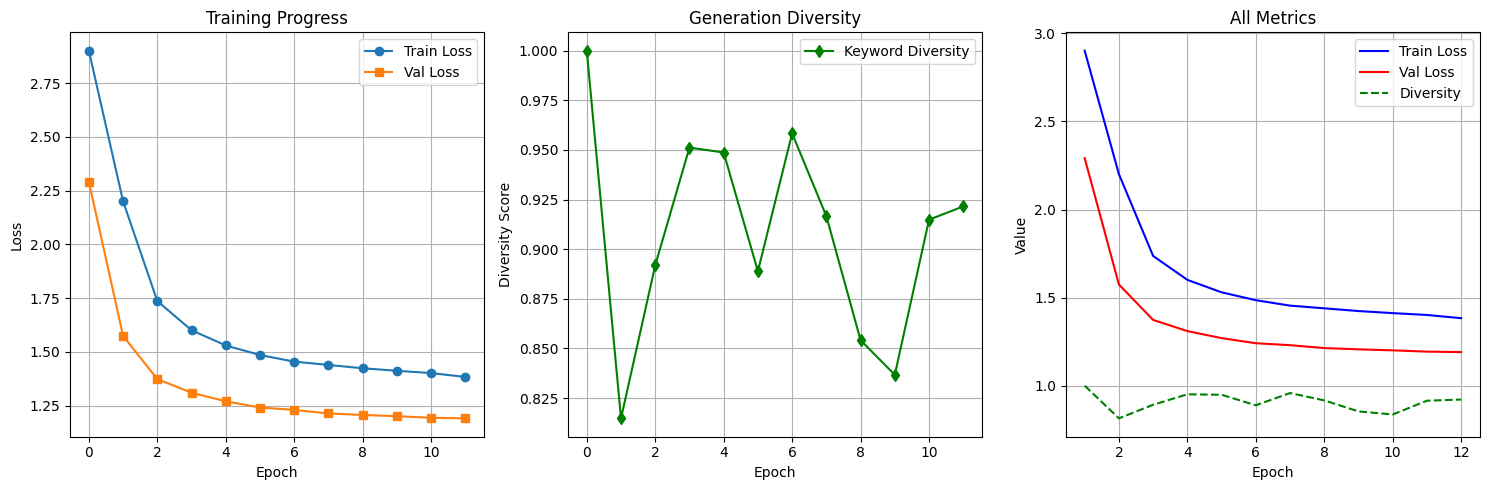


✅ LoRA Training complete!

🧪 Testing the LoRA trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs-best...
✅ LoRA model loaded successfully!

🧪 Testing with 3 personalities...

🧪 Test Case 1/3
📌 James Bond (Secret Agent (Fictional Character)) - British
📅 Period: Cold War Era, Late 20th Century

🎯 Variation 1:
Keywords: late 20th century british secret agent aesthetics, 007 code number aestheticie, high-tech gadgets and luxury lifestyle moodboard, cold war era spy agency aestheticise
📊 Quality Scores:
  • Visual: 1.25
  • Pinterest: 1.50
  • Diversity: 1.00

🧪 Test Case 2/3
📌 Queen Elizabeth II (British Monarch) - British
📅 Period: 20th-21st Century

🎯 Variation 1:
Keywords: 20th century british monarchy aesthetics, queen elizabeth ii portrait moodboard, decolonization of the britain royal palace aestheticis, modernization and social changes in the 21st century artifacts collection, 1952 to 2022 imperial age aestheti

In [ ]:
def main():
    """Main execution function"""

    try:
        set_seed(Config.SEED)
        mount_drive()

        trainer = PinterestLoRATrainer(Config)

        train_data, val_data = trainer.prepare_data(Config.DATASET_PATH)

        history = trainer.train(train_data, val_data)
        print("\n✅ LoRA Training complete!")

        print("\n🧪 Testing the LoRA trained model...")

        generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

        test_cases = [
          {
            "personality_name": "James Bond",
            "role": "Secret Agent (Fictional Character)",
            "culture_region": "British",
            "time_period": "Cold War Era, Late 20th Century",
            "bio": "James Bond is a fictional British secret agent created by author Ian Fleming in 1953. Known by his code number 007, he works for MI6 and is characterized by his sophistication, advanced gadgets, luxury lifestyle, and missions against international criminal organizations."
          },
          {
            "personality_name": "Queen Elizabeth II",
            "role": "British Monarch",
            "culture_region": "British",
            "time_period": "20th-21st Century",
            "bio": "Queen Elizabeth II was the longest-reigning British monarch in history, ruling from 1952 until her death in 2022. She presided over the decolonization of the British Empire, modernization of the monarchy, and significant social changes throughout her 70-year reign."
          },
          {
            "personality_name": "Florence Nightingale",
            "role": "Nurse, Healthcare Reformer",
            "culture_region": "British",
            "time_period": "Victorian Era, 19th Century",
            "bio": "Florence Nightingale was a British nurse and social reformer who revolutionized healthcare during the Crimean War. Known as 'The Lady with the Lamp,' she established modern nursing principles, improved hospital sanitation, and used statistical analysis to advocate for medical reform."
          }
        ]

        print(f"\n🧪 Testing with {len(test_cases)} personalities...")

        for i, test_case in enumerate(test_cases, 1):
            print(f"\n{'='*60}")
            print(f"🧪 Test Case {i}/{len(test_cases)}")
            print(f"{'='*60}")

            result = generator.generate(**test_case)

            print(f"📌 {result['personality']} ({result['role']}) - {result['culture_region']}")
            print(f"📅 Period: {result['time_period']}")

            for j, variation in enumerate(result['variations'], 1):
                print(f"\n🎯 Variation {j}:")
                print(f"Keywords: {variation['keywords']}")
                print(f"📊 Quality Scores:")
                print(f"  • Visual: {variation['quality']['visual_score']:.2f}")
                print(f"  • Pinterest: {variation['quality']['pinterest_score']:.2f}")
                print(f"  • Diversity: {variation['quality']['keyword_diversity']:.2f}")

        print("\n🎉 LoRA Pipeline complete! Your model is ready for Pinterest keyword generation.")

    except Exception as e:
        print(f"\n❌ Error occurred: {str(e)}")
        import traceback
        traceback.print_exc()
        raise

if __name__ == "__main__":
    main()

## 1.10 Testing The Trained Model

In [ ]:
print("\n🧪 Testing the trained model...")

generator = PinterestLoRAGenerator(f"{Config.MODEL_SAVE_PATH}-best")

test_cases = [
      {
        "personality_name": "Spider-Man",
        "role": "Superhero (Fictional Character)",
        "culture_region": "American",
        "time_period": "Modern Comics Era, 1960s-Present",
        "bio": "Spider-Man (Peter Parker) is a fictional American superhero created by Stan Lee and Steve Ditko for Marvel Comics in 1962. A teenager who gains spider powers from a radioactive spider bite, he becomes New York City's web-slinging hero guided by the principle 'With great power comes great responsibility.'"
      },
      {
        "personality_name": "Iron Man",
        "role": "Superhero/Inventor (Fictional Character)",
        "culture_region": "American",
        "time_period": "Modern Comics Era, 1960s-Present",
        "bio": "Iron Man (Tony Stark) is a fictional American superhero created by Stan Lee and others for Marvel Comics in 1963. A billionaire inventor who builds a powered armor suit, he transforms from weapons manufacturer to heroic protector, using his technological genius to fight global threats."
      },
      {
        "personality_name": "Mother Teresa",
        "role": "Catholic Missionary, Humanitarian",
        "culture_region": "Albanian-Indian",
        "time_period": "20th Century, Modern Era",
        "bio": "Mother Teresa was an Albanian-born Catholic missionary who devoted her life to serving the poor in Kolkata, India. She founded the Missionaries of Charity, won the Nobel Peace Prize in 1979, and was canonized as a saint in 2016 for her humanitarian work."
      },
      {
        "personality_name": "Al-Ghazali",
        "role": "Islamic Philosopher, Theologian",
        "culture_region": "Persian",
        "time_period": "Islamic Golden Age, 11th-12th Century",
        "bio": "Al-Ghazali was a Persian Islamic scholar who synthesized Sufi mysticism with orthodox theology and critiqued Aristotelian philosophy. His work 'The Incoherence of the Philosophers' reshaped Islamic thought, making him one of Islam's most influential theologians and philosophers."
      },
      {
        "personality_name": "Napoleon Bonaparte",
        "role": "Military Leader, French Emperor",
        "culture_region": "French",
        "time_period": "Revolutionary/Napoleonic Era, Late 18th-Early 19th Century",
        "bio": "Napoleon Bonaparte was a French military genius who rose during the French Revolution to become Emperor of France. He conquered much of Europe, established the Napoleonic Code, and implemented lasting administrative and legal reforms before his defeat at Waterloo in 1815."
      }
    ]


for test_case in test_cases:
  result = generator.generate(**test_case)

  print(f"\n📌 {result['personality']} ({result['role']})")
  for i, variation in enumerate(result['variations'], 1):
    print(f"\nVariation {i}:")
    print(f"Keywords: {variation['keywords']}")
    print(f"Visual Score: {variation['quality']['visual_score']:.2f}")
    print(f"Pinterest Score: {variation['quality']['pinterest_score']:.2f}")

print("\n🎉 Pipeline complete! The model is ready for Pinterest keyword generation.")




🧪 Testing the trained model...
Loading LoRA model from /content/drive/MyDrive/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs-best...
✅ LoRA model loaded successfully!

📌 Spider-Man (Superhero (Fictional Character))

Variation 1:
Keywords: 1960s comics aesthetics, steve ditko spider-man artboard, radioactive spider bite art board, new york city web-slinging hero aestheticion, spider powers aestheticism, american superhero concept art, 1962 comic book era visuals
Visual Score: 1.00
Pinterest Score: 0.71

📌 Iron Man (Superhero/Inventor (Fictional Character))

Variation 1:
Keywords: 1960s comics aesthetics, tony stark superhero aestheticie, superman armor suit moodboard, american superhero aestheticist, 1963 science fiction aestheticise
Visual Score: 1.00
Pinterest Score: 1.20

📌 Mother Teresa (Catholic Missionary, Humanitarian)

Variation 1:
Keywords: 20th century california aesthetics, mother thérèse missionary portrait moodboard, margaret teresa canonization artwork, christ

# 2. Deploying To HuggingFace

## 2.1 Installing Packages

In [ ]:
!pip install huggingface_hub peft -q

## 2.2 Importing Packages

In [ ]:
import time
import os
import shutil
import traceback
from pathlib import Path

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    GenerationConfig,
    pipeline
)
from peft import PeftModel, PeftConfig
from huggingface_hub import (
    HfApi,
    notebook_login,
    create_repo,
    delete_repo,
    repo_exists
)

## 2.3 HuggingFace Deployment Configuration Class

In [ ]:
class DeployConfig:
    """Deployment configuration - matches training parameters"""

    LORA_MODEL_PATH = "/content/drive/MyDrive/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs-final"
    BASE_MODEL_NAME = "google/flan-t5-base"

    HF_USERNAME = "Amama02"
    MODEL_NAME = "pinterest-personality-keywords-reduced-epochs"

    PRIVATE_REPO = False
    FORCE_RECREATE = True

    USE_SAFETENSORS = True
    TORCH_DTYPE = torch.float16 if torch.cuda.is_available() else torch.float32

    MAX_INPUT_LEN = 220
    MAX_TARGET_LEN = 120

    GENERATION_PARAMS = {
        "max_length": 120,
        "num_beams": 6,
        "temperature": 0.8,
        "do_sample": True,
        "top_p": 0.95,
        "repetition_penalty": 1.8,
        "length_penalty": 1.1,
        "early_stopping": True,
        "no_repeat_ngram_size": 2,
    }

    @property
    def repo_name(self):
        return f"{self.HF_USERNAME}/{self.MODEL_NAME}"

    @property
    def repo_url(self):
        return f"https://huggingface.co/{self.repo_name}"

config = DeployConfig()

print("🚀 LoRA Deployment Configuration")
print("=" * 60)
print(f"📁 LoRA Model Path: {config.LORA_MODEL_PATH}")
print(f"🤗 Target Repository: {config.repo_name}")
print(f"🌐 Repository URL: {config.repo_url}")
print(f"🔒 Private Repository: {config.PRIVATE_REPO}")
print(f"🔄 Force Recreate: {config.FORCE_RECREATE}")

🚀 LoRA Deployment Configuration
📁 LoRA Model Path: /content/drive/MyDrive/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs-final
🤗 Target Repository: Amama02/pinterest-personality-keywords-reduced-epochs
🌐 Repository URL: https://huggingface.co/Amama02/pinterest-personality-keywords-reduced-epochs
🔒 Private Repository: False
🔄 Force Recreate: True


## 2.4 Authenticating To HuggingFace

In [ ]:
def authenticate_huggingface():
    """HuggingFace authentication with retry"""

    max_retries = 3
    for attempt in range(max_retries):
        try:
            print(f"🔐 HuggingFace Authentication (Attempt {attempt + 1}/{max_retries})")
            notebook_login()

            api = HfApi()
            user_info = api.whoami()
            print(f"✅ Successfully authenticated as: {user_info['name']}")

            if user_info['name'] != config.HF_USERNAME:
                print(f"⚠️ Warning: Logged in as '{user_info['name']}' but config shows '{config.HF_USERNAME}'")
                response = input("Continue anyway? (y/n): ")
                if response.lower() != 'y':
                    return False

            return True

        except Exception as e:
            print(f"❌ Authentication failed: {e}")
            if attempt < max_retries - 1:
                print("Retrying in 5 seconds...")
                time.sleep(5)
            else:
                print("❌ Authentication failed after all retries")
                return False

    return False
authenticate_huggingface()

## 2.5 Model Loading

In [ ]:
def validate_and_load_models():
    """Validate paths and load models with comprehensive error handling"""

    print("\n📋 Model Validation and Loading")
    print("=" * 50)

    # Check if LoRA model exists
    if not os.path.exists(config.LORA_MODEL_PATH):
        print(f"❌ LoRA model not found at: {config.LORA_MODEL_PATH}")
        print("Available paths in drive:")
        try:
            drive_path = "/content/drive/MyDrive"
            for item in os.listdir(drive_path):
                if "lora" in item.lower() or "pinterest" in item.lower():
                    print(f"  📁 {os.path.join(drive_path, item)}")
        except:
            pass
        return None, None, None

    print(f"✅ LoRA model found at: {config.LORA_MODEL_PATH}")

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"🖥️ Using device: {device}")

        print("📝 Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(config.LORA_MODEL_PATH)
        if tokenizer.pad_token is None:
            tokenizer.pad_token = tokenizer.eos_token
        print("✅ Tokenizer loaded successfully")

        print(f"🧠 Loading base model: {config.BASE_MODEL_NAME}")
        base_model = AutoModelForSeq2SeqLM.from_pretrained(
            config.BASE_MODEL_NAME,
            torch_dtype=config.TORCH_DTYPE,
            device_map="auto" if torch.cuda.is_available() else None,
            trust_remote_code=True
        )
        print("✅ Base model loaded successfully")

        print("🔧 Loading LoRA configuration...")
        peft_config = PeftConfig.from_pretrained(config.LORA_MODEL_PATH)
        print(f"✅ LoRA config loaded - Type: {peft_config.peft_type}, Rank: {peft_config.r}")

        print("🔀 Loading and merging LoRA adapter...")
        lora_model = PeftModel.from_pretrained(base_model, config.LORA_MODEL_PATH)
        merged_model = lora_model.merge_and_unload()
        print("✅ LoRA merged successfully")

        generation_config = GenerationConfig(
            pad_token_id=tokenizer.pad_token_id,
            eos_token_id=tokenizer.eos_token_id,
            bos_token_id=tokenizer.bos_token_id if hasattr(tokenizer, 'bos_token_id') else None,
            **config.GENERATION_PARAMS
        )

        print("✅ All models loaded and validated successfully")
        return merged_model, tokenizer, generation_config

    except Exception as e:
        print(f"❌ Model loading failed: {str(e)}")
        print("Full error traceback:")
        traceback.print_exc()
        return None, None, None

## 2.6 Repo Management Function

In [ ]:
def manage_repository():
    """Repository management with deletion and recreation"""

    print(f"\n📦 Repository Management: {config.repo_name}")
    print("=" * 50)

    api = HfApi()

    try:
        repo_exists_flag = repo_exists(config.repo_name)
        print(f"📊 Repository exists: {repo_exists_flag}")

        if repo_exists_flag:
            if config.FORCE_RECREATE:
                print("🗑️ Force recreate enabled - deleting existing repository...")
                try:
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted successfully")
                    time.sleep(2)  # Wait a moment
                except Exception as e:
                    print(f"⚠️ Delete warning (might be already deleted): {e}")
            else:
                print("⚠️ Repository exists and force recreate is disabled")
                response = input("Delete and recreate? (y/n): ")
                if response.lower() == 'y':
                    delete_repo(config.repo_name, repo_type="model")
                    print("✅ Repository deleted")
                    time.sleep(2)
                else:
                    print("📝 Will update existing repository")

        print("🆕 Creating repository...")
        repo_url = create_repo(
            config.repo_name,
            private=config.PRIVATE_REPO,
            exist_ok=True,
            repo_type="model"
        )
        print(f"✅ Repository created/confirmed: {repo_url}")
        return True

    except Exception as e:
        print(f"❌ Repository management failed: {str(e)}")
        traceback.print_exc()
        return False


## 2.7 Model Card Creation Function

In [ ]:
def create_enhanced_model_card():
    """Create a model card with examples"""

    model_card = f"""---
language: en
license: apache-2.0
base_model: {config.BASE_MODEL_NAME}
tags:
- text2text-generation
- pinterest
- keywords
- personality
- fine-tuned
- lora
- flan-t5
library_name: transformers
pipeline_tag: text2text-generation
widget:
- text: "Generate Pinterest keywords for Cleopatra - Culture: Egyptian | Role: Royalty | Period: Ancient Egypt - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Cleopatra Keywords"
- text: "Generate Pinterest keywords for Leonardo da Vinci - Culture: Italian | Role: Polymath | Period: Renaissance - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"
  example_title: "Leonardo da Vinci Keywords"
---

# Pinterest Personality Keywords Generator

🎨 **Fine-tuned FLAN-T5 model for generating Pinterest-optimized keywords for historical and fictional personalities.**

This model was fine-tuned using LoRA (Low-Rank Adaptation) to generate visually appealing, searchable Pinterest keywords based on personality information.

## 🚀 Quick Start

### Using Transformers Pipeline
```python
from transformers import pipeline

# Load the model
generator = pipeline("text2text-generation", model="{config.repo_name}")

# Generate keywords
input_text = "Generate Pinterest keywords for Marie Curie - Culture: Polish-French | Role: Scientist | Period: Early 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

result = generator(
    input_text,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    no_repeat_ngram_size=2
)

print(result[0]['generated_text'])
```

### Using Direct Model Loading
```python
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("{config.repo_name}")
model = AutoModelForSeq2SeqLM.from_pretrained("{config.repo_name}")

# Prepare input
input_text = "Generate Pinterest keywords for Frida Kahlo - Culture: Mexican | Role: Artist | Period: 20th Century - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords"

# Tokenize and generate
inputs = tokenizer(input_text, return_tensors="pt", max_length=256, truncation=True)
outputs = model.generate(
    **inputs,
    max_length=300,
    num_beams=8,
    temperature=0.9,
    do_sample=True,
    top_p=0.95,
    repetition_penalty=2.0,
    length_penalty=1.2,
    early_stopping=True,
    no_repeat_ngram_size=2
)

keywords = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(keywords)
```

## 📝 Input Format

The model expects input in this specific format:

```
Generate Pinterest keywords for [PERSONALITY_NAME] - Culture: [CULTURE] | Role: [ROLE] | Period: [TIME_PERIOD] | Bio: [BIOGRAPHY] - Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and bio give important information about the personality. Take them into account when generating keywords
```

### Required Fields:
- **PERSONALITY_NAME**: Name of the person
- **Culture**: Cultural background or nationality
- **Role**: Profession, title, or main role
- **Period**: Historical time period
- **Bio**: (Optional) Brief biography

## 🎯 Example Outputs

| Input | Generated Keywords |
|-------|-------------------|
| **Cleopatra** (Egyptian Royalty, Ancient Egypt) | "Egyptian queen aesthetic, ancient Egypt fashion, Cleopatra makeup, pharaoh style, golden jewelry, Egyptian mythology, ancient beauty, royal Egyptian, hieroglyphics, Egyptian art" |
| **Leonardo da Vinci** (Italian Polymath, Renaissance) | "Renaissance art, Italian genius, classical paintings, Renaissance fashion, vintage sketches, Italian Renaissance, Renaissance architecture, classical art history" |
| **Marie Curie** (Polish-French Scientist, Early 20th Century) | "vintage science, female scientist aesthetic, laboratory vintage, early 1900s fashion, women in science, vintage academic, scientific discovery, vintage portraits" |

## ⚙️ Generation Parameters

The model is optimized with these generation settings:

- **max_length**: 300
- **num_beams**: 8
- **temperature**: 0.9
- **top_p**: 0.95
- **repetition_penalty**: 2.0
- **length_penalty**: 1.2
- **no_repeat_ngram_size**: 2

## 🔧 Technical Details

- **Base Model**: {config.BASE_MODEL_NAME}
- **Fine-tuning Method**: LoRA (Low-Rank Adaptation)
- **LoRA Rank**: 16
- **Target Modules**: ["q", "v", "k", "o", "wi", "wo"]
- **Training Data**: Historical and fictional personalities dataset
- **Task**: Seq2Seq text generation

The model has been optimized for:
- ✅ **Visual Keywords**: Generates terms that work well for image searches
- ✅ **Pinterest Optimization**: Keywords tailored for Pinterest's search algorithm
- ✅ **Cultural Sensitivity**: Respects cultural context and historical accuracy
- ✅ **Diversity**: Produces varied and creative keyword combinations

## 🚫 Limitations

- Specifically designed for Pinterest keyword generation
- May not perform well on other text generation tasks
- Limited to personalities with sufficient historical/cultural context
- Requires specific input format for optimal results


"""
    return model_card


## 2.8 Model Deployment Function

In [ ]:
def deploy_model_with_retry():
    """Deploy model with retry logic and error handling"""

    print(f"\n📤 Model Deployment")
    print("=" * 50)

    # Load models
    merged_model, tokenizer, generation_config = validate_and_load_models()
    if merged_model is None:
        return False

    # Manage repository
    if not manage_repository():
        return False

    max_retries = 3
    api = HfApi()

    for attempt in range(max_retries):
        temp_dir = None
        try:
            print(f"\n📤 Upload Attempt {attempt + 1}/{max_retries}")

            # Create temporary directory for uploads
            temp_dir = Path("./temp_model_deploy")
            temp_dir.mkdir(exist_ok=True)

            # Save model locally first
            print("💾 Saving model locally...")
            merged_model.save_pretrained(
                temp_dir,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("💾 Saving tokenizer locally...")
            tokenizer.save_pretrained(temp_dir)

            print("💾 Saving generation config locally...")
            generation_config.save_pretrained(temp_dir)

            # Create model card
            model_card = create_enhanced_model_card()
            with open(temp_dir / "README.md", "w", encoding="utf-8") as f:
                f.write(model_card)

            # Create enhanced metadata
            metadata = {
                "model_info": {
                    "base_model": config.BASE_MODEL_NAME,
                    "fine_tuning_method": "LoRA",
                    "max_input_length": config.MAX_INPUT_LEN,
                    "max_target_length": config.MAX_TARGET_LEN,
                    "generation_parameters": config.GENERATION_PARAMS,
                    "deployment_date": time.strftime("%Y-%m-%d %H:%M:%S"),
                    "torch_dtype": str(config.TORCH_DTYPE)
                },
                "usage": {
                    "input_format": "Generate Pinterest keywords for the personality {name}. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and Bio give important information about the personality. Take them into account when generating keywords. | Culture: {culture} | Role: {role} | Period: {period} | Bio: {bio}",
                    "example_prompt": "Generate Pinterest keywords for the personality Albert Einstein. Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. The Culture, Role, Period and Bio give important information about the personality. Take them into account when generating keywords. | Culture: German-American | Role: Physicist | Period: 20th Century | Bio: Theoretical physicist famous for theory of relativity"
                }
            }

            with open(temp_dir / "model_metadata.json", "w") as f:
                json.dump(metadata, f, indent=2)

            print("🚀 Uploading model to Hub...")
            merged_model.push_to_hub(
                config.repo_name,
                private=config.PRIVATE_REPO,
                safe_serialization=config.USE_SAFETENSORS,
                max_shard_size="2GB"
            )

            print("🚀 Uploading tokenizer to Hub...")
            tokenizer.push_to_hub(config.repo_name, private=config.PRIVATE_REPO)

            print("📋 Uploading additional files...")
            files_to_upload = [
                ("README.md", "README.md"),
                ("generation_config.json", "generation_config.json"),
                ("model_metadata.json", "model_metadata.json")
            ]

            for local_file, repo_file in files_to_upload:
                local_path = temp_dir / local_file
                if local_path.exists():
                    api.upload_file(
                        path_or_fileobj=str(local_path),
                        path_in_repo=repo_file,
                        repo_id=config.repo_name,
                        repo_type="model"
                    )
                    print(f"  ✅ Uploaded {repo_file}")

            shutil.rmtree(temp_dir, ignore_errors=True)

            print(f"✅ Model successfully deployed!")
            print(f"🌐 Model URL: {config.repo_url}")
            return True

        except Exception as e:
            print(f"❌ Upload attempt {attempt + 1} failed: {str(e)}")

            if temp_dir and temp_dir.exists():
                shutil.rmtree(temp_dir, ignore_errors=True)

            if attempt < max_retries - 1:
                print("⏳ Waiting 10 seconds before retry...")
                time.sleep(10)
            else:
                print("❌ All upload attempts failed")
                traceback.print_exc()

    return False

## 2.9 Deplyment Main Function

In [ ]:
def main():
    """Main execution function with comprehensive error handling"""

    print("🚀 LORA MODEL DEPLOYMENT")
    print("=" * 60)
    print(f"🎯 Target: {config.repo_name}")
    print(f"🌐 URL: {config.repo_url}")
    print("=" * 60)

    if not deploy_model_with_retry():
        print("❌ Deployment failed")
        return False

    print("\n" + "🎉"*20)
    print("🎉 DEPLOYMENT SUCCESSFUL! 🎉")
    print("🎉"*20)
    print(f"\n📍 The model is live at: {config.repo_url}")

    return True

In [ ]:
if __name__ == "__main__":

    print(f"\n📋 Ready to deploy to: {config.repo_name}")
    print(f"🔄 Force recreate: {config.FORCE_RECREATE}")

    if os.path.exists(config.LORA_MODEL_PATH):
        success = main()
        if success:
            print("\n🎊 Deployment pipeline completed successfully!")
        else:
            print("\n💥 Deployment pipeline failed")
    else:
        print("\n⚠️fix configuration issues")


📋 Ready to deploy to: Amama02/pinterest-personality-keywords-reduced-epochs
🔄 Force recreate: True
🚀 LORA MODEL DEPLOYMENT
🎯 Target: Amama02/pinterest-personality-keywords-reduced-epochs
🌐 URL: https://huggingface.co/Amama02/pinterest-personality-keywords-reduced-epochs

📤 Model Deployment

📋 Model Validation and Loading
✅ LoRA model found at: /content/drive/MyDrive/pinterest-flan-t5-finetuned-model-25-August-reduced-epochs-final
🖥️ Using device: cuda
📝 Loading tokenizer...
✅ Tokenizer loaded successfully
🧠 Loading base model: google/flan-t5-base
✅ Base model loaded successfully
🔧 Loading LoRA configuration...
✅ LoRA config loaded - Type: PeftType.LORA, Rank: 16
🔀 Loading and merging LoRA adapter...
✅ LoRA merged successfully
✅ All models loaded and validated successfully

📦 Repository Management: Amama02/pinterest-personality-keywords-reduced-epochs
📊 Repository exists: False
🆕 Creating repository...
✅ Repository created/confirmed: https://huggingface.co/Amama02/pinterest-personality

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpcr5h71u5/model.safetensors    :   0%|          |  552kB /  571MB            

🚀 Uploading tokenizer to Hub...


README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  /tmp/tmpenx7c12y/spiece.model         : 100%|##########|  792kB /  792kB            

📋 Uploading additional files...
  ✅ Uploaded README.md
  ✅ Uploaded generation_config.json
  ✅ Uploaded model_metadata.json
✅ Model successfully deployed!
🌐 Model URL: https://huggingface.co/Amama02/pinterest-personality-keywords-reduced-epochs

🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉
🎉 DEPLOYMENT SUCCESSFUL! 🎉
🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉🎉

📍 The model is live at: https://huggingface.co/Amama02/pinterest-personality-keywords-reduced-epochs

🎊 Deployment pipeline completed successfully!


## 2.10 Testing Deployed Model

In [ ]:
import time
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
)

In [ ]:
REPO_NAME = "Amama02/pinterest-personality-keywords-reduced-epochs"

In [ ]:
class ModelTester:
    """Model tester with correct training parameters"""

    def __init__(self, repo_name: str):
        self.repo_name = repo_name
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = None
        self.tokenizer = None

        self.MAX_INPUT_LEN = 220
        self.MAX_TARGET_LEN = 120

        self.GENERATION_PARAMS = {
            "max_length": 120,
            "num_beams": 8,
            "temperature": 0.7,
            "do_sample": True,
            "top_p": 0.95,
            "repetition_penalty": 1.8,
            "length_penalty": 1.1,   
            "early_stopping": True,
            "no_repeat_ngram_size": 2,
        }

    def load_model(self):
        """Load model with proper token configuration"""
        print(f"📥 Loading model from Hub: {self.repo_name}")

        try:
            self.tokenizer = AutoTokenizer.from_pretrained(self.repo_name)

            self.model = AutoModelForSeq2SeqLM.from_pretrained(
                self.repo_name,
                torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32
            )
            self.model = self.model.to(self.device)

            if self.tokenizer.pad_token is None:
                self.tokenizer.pad_token = self.tokenizer.eos_token

            if self.model.config.decoder_start_token_id is None:
                self.model.config.decoder_start_token_id = self.tokenizer.pad_token_id

            if not hasattr(self.model.config, 'bos_token_id') or self.model.config.bos_token_id is None:
                self.model.config.bos_token_id = self.tokenizer.pad_token_id

            print("✅ Model loaded and configured successfully!")
            print(f"🖥️ Using device: {self.device}")

            print("🔍 Generation Parameters:")
            for key, value in self.GENERATION_PARAMS.items():
                print(f"  {key}: {value}")

            return True

        except Exception as e:
            print(f"❌ Error loading model: {str(e)}")
            import traceback
            traceback.print_exc()
            return False

    def clean_aesthetics_variants(self, text):
        """Fix corrupted 'aesthetics' words while preserving correct ones"""
        import re

        replacements = {
            r'\baestheticis\b': 'aesthetics',
            r'\baestheticise\b': 'aesthetics',
            r'\baesthetica\b': 'aesthetics',
            r'\baesthetico\b': 'aesthetics',
            r'\baesthetic[b-z]{1,4}\b': 'aesthetics', 
        }

        for pattern, replacement in replacements.items():
            text = re.sub(pattern, replacement, text, flags=re.IGNORECASE)

        return text

    def generate_keywords(self, personality_name: str, role: str = "",
                         culture_region: str = "", time_period: str = "", bio: str = "",
                         custom_params: dict = None):
        """Generate keywords with correct parameters matching training"""

        if self.model is None or self.tokenizer is None:
            raise ValueError("Model not loaded. Call load_model() first.")

        input_parts = [
            f"Generate Pinterest keywords ONLY for the personality {personality_name}. "
            f"Use ONLY information from the provided context fields. "
            f"Keywords should be visual, searchable on Pinterest, and capture their aesthetic essence. "
            f"DO NOT add information not mentioned in the context. "
            f"Base keywords strictly on the Culture, Role, Period and Bio provided."
        ]

        context_parts = []
        if culture_region:
            context_parts.append(f"Culture: {culture_region}")
        if role:
            context_parts.append(f"Role: {role}")
        if time_period:
            context_parts.append(f"Period: {time_period}")
        if bio:
            context_parts.append(f"Bio: {bio}")

        if context_parts:
            input_parts.append(" | ".join(context_parts))

        input_parts.append("Generate keywords based STRICTLY on the above context only.")

        prompt = " - ".join(input_parts)

        inputs = self.tokenizer(
            prompt,
            return_tensors="pt",
            max_length=self.MAX_INPUT_LEN,
            truncation=True,
            padding=True
        )

        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        gen_params = custom_params if custom_params else self.GENERATION_PARAMS.copy()

        gen_params.update({
            "pad_token_id": self.tokenizer.pad_token_id,
            "eos_token_id": self.tokenizer.eos_token_id,
            "decoder_start_token_id": self.model.config.decoder_start_token_id,
            "use_cache": True
        })

        with torch.no_grad():
            outputs = self.model.generate(**inputs, **gen_params)

        generated_text = self.tokenizer.decode(outputs[0], skip_special_tokens=True)

        generated_text = self.clean_aesthetics_variants(generated_text)

        return generated_text

    def test_parameter_variations(self, test_case):
        """Test different parameter settings"""
        print(f"\n🔬 Parameter Variation Testing for {test_case['personality_name']}")

        # Test with training parameters
        print("\n📊 Training Parameters:")
        result1 = self.generate_keywords(**test_case)
        print(f"Result: {result1}")

        # Test with more conservative parameters
        print("\n📊 Conservative Parameters:")
        conservative_params = {
            "max_length": 120,
            "num_beams": 8,
            "temperature": 0.7,
            "do_sample": True,
            "top_p": 0.9,
            "repetition_penalty": 1.5,
            "length_penalty": 1.0,
            "early_stopping": True,
            "no_repeat_ngram_size": 2,
        }
        result2 = self.generate_keywords(**test_case, custom_params=conservative_params)
        print(f"Result: {result2}")

    def run_comprehensive_test(self):
        """Run comprehensive tests with correct parameters"""

        test_cases = [
          {
            "personality_name": "Cleopatra",
            "role": "Pharaoh, Political Leader",
            "culture_region": "Egyptian/Greek",
            "time_period": "Ptolemaic Dynasty, 1st Century BCE",
            "bio": "Cleopatra VII was the last active pharaoh of Ptolemaic Egypt, known for her intelligence, political skill, and strategic alliances with Julius Caesar and Mark Antony. She spoke multiple languages and was highly educated in mathematics and philosophy."
          },
          {
            "personality_name": "Leonardo da Vinci",
            "role": "Artist, Inventor, Scientist",
            "culture_region": "Italian",
            "time_period": "Renaissance, 15th-16th Century",
            "bio": "Leonardo da Vinci was an Italian Renaissance polymath who excelled in painting, engineering, anatomy, and invention. Creator of the 'Mona Lisa' and 'The Last Supper,' he embodied Renaissance humanism through his scientific studies and artistic masterworks."
          },
          {
            "personality_name": "Frida Kahlo",
            "role": "Artist, Painter",
            "culture_region": "Mexican",
            "time_period": "20th Century, Modern Art Era",
            "bio": "Frida Kahlo was a Mexican artist known for her symbolic self-portraits exploring pain, identity, and Mexican culture. Her bold visual style combined surrealist elements with Mexican folk art, making her an icon of feminist and cultural expression."
          },
          {
            "personality_name": "Marie Curie",
            "role": "Physicist, Chemist",
            "culture_region": "Polish-French",
            "time_period": "Early 20th Century, Scientific Revolution",
            "bio": "Marie Curie was a Polish-French physicist and chemist who discovered polonium and radium and developed the theory of radioactivity. She was the first woman to win a Nobel Prize and remains the only person to win Nobel Prizes in two different sciences."
          },
          {
          "personality_name": "Marcus Aurelius",
          "culture_region": "Roman",
          "role": "Roman Emperor, Stoic Philosopher, Writer",
          "time_period": "Pax Romana, 2nd Century",
          "bio": "Marcus Aurelius (121-180 AD) was a Roman Emperor and Stoic philosopher, author of *Meditations*, a personal journal reflecting on Stoic principles. He ruled during a time of war and plague, demonstrating resilience and duty. His philosophical writings emphasize virtue, reason, and acceptance of fate, profoundly influencing Western thought and ethical philosophy."
          }
        ]

        print(f"\n🧪 Running {len(test_cases)} test cases with...")
        print("=" * 80)
        print(f"📋 Using Parameters: Input Length={self.MAX_INPUT_LEN}, Target Length={self.MAX_TARGET_LEN}")
        print(f"📋 Generation: Beams={self.GENERATION_PARAMS['num_beams']}, Temp={self.GENERATION_PARAMS['temperature']}")

        for i, test_case in enumerate(test_cases, 1):
            print(f"\n🎭 Test {i}: {test_case['personality_name']}")
            print(f"📝 Context: {test_case['role']} | {test_case['culture_region']} | {test_case['time_period']}")
            print(f"📖 Bio: {test_case['bio'][:100]}{'...' if len(test_case['bio']) > 100 else ''}")

            try:
                start_time = time.time()
                keywords = self.generate_keywords(**test_case)
                generation_time = time.time() - start_time

                print(f"\n🎯 Generated Keywords:")
                print(f"   {keywords}")
                print(f"⏱️ Generation Time: {generation_time:.2f}s")

                keyword_list = [k.strip() for k in keywords.split(',') if k.strip()]
                print(f"📊 Keyword Count: {len(keyword_list)}")

                aesthetics_count = sum(1 for k in keyword_list if 'aesthetic' in k.lower())
                print(f"🎨 Aesthetics Keywords: {aesthetics_count}")

                if len(keyword_list) > 0:
                    print(f"🔍 Sample Keywords: {', '.join(keyword_list[:5])}...")

                if i == 1:
                    self.test_parameter_variations(test_case)

                print("-" * 80)

            except Exception as e:
                print(f"❌ Error generating keywords: {str(e)}")
                import traceback
                traceback.print_exc()
                print("-" * 80)

        print(f"\n✅ All tests completed!")

def test_deployed_model(repo_name: str):
    """Test the deployed model"""
    tester = ModelTester(repo_name)

    if tester.load_model():
        tester.run_comprehensive_test()
    else:
        print("❌ Failed to load model for testing")

test_deployed_model("Amama02/pinterest-personality-keywords-reduced-epochs")

📥 Loading model from Hub: Amama02/pinterest-personality-keywords-reduced-epochs


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/571M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/289 [00:00<?, ?B/s]

✅ Model loaded and configured successfully!
🖥️ Using device: cuda
🔍 Generation Parameters:
  max_length: 120
  num_beams: 8
  temperature: 0.7
  do_sample: True
  top_p: 0.95
  repetition_penalty: 1.8
  length_penalty: 1.1
  early_stopping: True
  no_repeat_ngram_size: 2

🧪 Running 5 test cases with...
📋 Using Parameters: Input Length=220, Target Length=120
📋 Generation: Beams=8, Temp=0.7

🎭 Test 1: Cleopatra
📝 Context: Pharaoh, Political Leader | Egyptian/Greek | Ptolemaic Dynasty, 1st Century BCE
📖 Bio: Cleopatra VII was the last active pharaoh of Ptolemaic Egypt, known for her intelligence, political ...

🎯 Generated Keywords:
   1st century bce ptolemaic aesthetics, cleopatra king portrait moodboard, ancient egyptian dynasties artifacts collection, greek political leader portrait, classical maths and philosophy background, early pharyngeic era architecture, medieval philippine culture, 2nd century caesar palace decor
⏱️ Generation Time: 3.69s
📊 Keyword Count: 8
🎨 Aesthetics Keyword